In [426]:
import pandas as pd
import numpy as np
#pd.set_option("display.max_rows", None, "display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.read_csv('/Users/Brian/Dropbox/UTHealth/Humana Case Competition/2020_Competition_Training (1).csv', chunksize=10000)
df = df.read()
df = df.reindex()#sorted(df.columns), axis=1)
df.head()
# Dataset is now stored in a Pandas Dataframe

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2895: DtypeWarning: Columns (80,193) have mixed types.Specify dtype option on import or set low_memory=False.
  return runner(coro)


,person_id_syn,transportation_issues,src_platform_cd,sex_cd,est_age,smoker_current_ind,smoker_former_ind,lang_spoken_cd,mabh_seg,cci_score,...,submcc_rar_scl_ind,rx_gpi2_74_ind,rx_gpi2_89_ind,rx_gpi2_96_ind,submcc_rsk_obe_ind,rx_gpi2_22_ind,submcc_rsk_synx_ind,submcc_rsk_coag_ind,submcc_rsk_othr_ind,submcc_rsk_chol_ind
0,0002MOb79ST17bLYAe46eIc2,0,EM,F,62,1,0,ENG,UNK,3.0,...,0,0,0,0,0,0,0,0,0,0
1,0004cMOS6bTLf34Y7AIca8f3,0,EM,F,59,1,0,ENG,C2,1.0,...,0,0,0,0,1,0,0,0,0,1
2,000536M9O3ST98LaYaeA29Ia,1,EM,F,63,0,0,ENG,UNK,3.0,...,0,0,0,0,0,0,0,0,0,1
3,0009bMO9SfTLYe77A51I4ac3,0,EM,M,75,0,0,ENG,H6,3.0,...,0,0,0,0,1,0,0,0,0,1
4,000M7OeS66bTL8bY89Aa16Ie,0,EM,M,51,1,0,ENG,UNK,3.0,...,0,0,0,0,0,0,0,0,0,1


In [427]:
y = df['transportation_issues']
y.shape

(69572,)

In [428]:
df = df.drop(['zip_cd','person_id_syn'], axis=1)

In [429]:
df.shape

(69572, 824)

In [430]:
#impute missing values
from sklearn.impute import SimpleImputer

#get categorical feautes and convert all values to string
categorical_features = df.select_dtypes(include=['object']).columns
print(categorical_features)
df.loc[:,categorical_features].astype(str)

cat = SimpleImputer(strategy='most_frequent',copy=False)
cat1 = cat.fit(df[categorical_features].astype(str))
df[categorical_features] = cat1.transform(df[categorical_features])

Index(['src_platform_cd', 'sex_cd', 'lang_spoken_cd', 'mabh_seg',
       'cms_ra_factor_type_cd', 'cons_cmys', 'cons_hhcomp', 'cons_homstat',
       'hedis_ami', 'hedis_cmc_ldc_c_control', 'hedis_cmc_ldc_c_screen',
       'hedis_dia_eye', 'hedis_dia_hba1c_ge9', 'hedis_dia_hba1c_test',
       'hedis_dia_ldc_c_control', 'hedis_dia_ldc_c_screen',
       'hedis_dia_ma_nephr', 'rucc_category', 'cnty_cd', 'state_cd'],
      dtype='object')


In [431]:
#impute numeric
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
num = SimpleImputer(strategy='median',copy=False)
num1 = num.fit(df[numeric_features])
df[numeric_features] = num1.transform(df[numeric_features])

In [432]:
#get dummies on all categorical variables to create new numerical columns, then drop original columns
categorical_features = df.select_dtypes(include=['object']).columns
X = pd.get_dummies(df[categorical_features], prefix_sep='_')
X = pd.merge(df,X,how='outer',left_index=True,right_index=True)
X = X.drop(categorical_features, axis=1)
X.head()

,transportation_issues,est_age,smoker_current_ind,smoker_former_ind,cci_score,dcsi_score,fci_score,hcc_weighted_sum,betos_d1c_pmpm_ct,betos_d1d_pmpm_ct,...,state_cd_PR,state_cd_SC,state_cd_SD,state_cd_TN,state_cd_TX,state_cd_VA,state_cd_WA,state_cd_WI,state_cd_WV,state_cd_other
0,0.0,62.0,1.0,0.0,3.0,1.0,2.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,0.0,59.0,1.0,0.0,1.0,2.0,5.0,3.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,1.0,63.0,0.0,0.0,3.0,0.0,6.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,0.0,75.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,0.0,51.0,1.0,0.0,3.0,1.0,4.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


## feature engineering

In [435]:
#binary indicator for values > 75 percentile, and sqrt to amplify values
X['med_er_visit_high'] = np.where(X['med_er_visit_ct_pmpm'] > 0.1, 1, 0)

#binary indicator for values > 75 percentile, and sqrt to amplify values
X['total_er_visit_high'] = np.where(X['total_er_visit_ct_pmpm'] > 0.1, 1, 0)

X['med_plus_total_er_visit'] = X['med_er_visit_ct_pmpm'] + X['total_er_visit_ct_pmpm']

#combine codes for superficial injuries (likely falls)
#X['ccsp_236_239'] = X['ccsp_239_ind'] + X['ccsp_236_ind']

#combine low income indicators and square/cube to amplify
#X['low_inc'] = X['cms_dual_eligible_ind'] + X['cms_low_income_ind']

#combine behavioral health indicators and square/cube
#X['bh_tot'] = X['bh_cdto_ind'] + X['bh_bipr_ind'] + X['bh_dema_ind'] + X['bh_cdsb_ind'] + X['bh_aoth_ind']

#create binary column for high risk cms part d (anything above 75 percentile considered high risk)
X['cms_partd_high_risk'] = np.where(X['cms_partd_ra_factor_amt'] > 1.32, 1, 0)

#create binary column for high risk cms ma (anything above 75 percentile considered high risk)
X['cms_ma_high_risk'] = np.where(X['cms_ma_risk_score_nbr'] > 1.34, 1, 0)

#amplify correlated cms risk/payment amounts by squaring and cubing values
X['cms_tot_ma_payment_amt_sqrt'] = np.sqrt(X['cms_tot_ma_payment_amt'])

In [ ]:
#additional features

low_inc                                 154.072680
est_age                                 119.421419
ccsp_236_239                             80.907964
cms_tot_partd_payment_amt                78.778600
med_ambulance_visit_ct_pmpm              62.059773
total_ambulance_visit_ct_pmpm            52.921809
cms_rx_risk_score_nbr                    50.098201
cms_disabled_ind                         48.187203
bh_tot                                   47.511346

In [436]:
# create a list of our conditions
conditions = [
    (X['cms_rx_risk_score_nbr'] >= 1.84),
    (X['cms_rx_risk_score_nbr'] >= 1.04) & (X['cms_rx_risk_score_nbr'] <= 1.84),
    (X['cms_rx_risk_score_nbr'] >= 0.24) & (X['cms_rx_risk_score_nbr'] <= 1.04),
    (X['cms_rx_risk_score_nbr'] >= 0) & (X['cms_rx_risk_score_nbr'] <= 0.24),
    ]
# create a list of the values we want to assign for each condition
values = [4,3,2,1]
# create a new column and use np.select to assign values to it using our lists as arguments
X['cms_rx_risk_score_grp'] = np.select(conditions, values)
# display updated DataFrame
X['cms_rx_risk_score_grp'].value_counts()

2    40464
3    18621
4     6726
1     3761
Name: cms_rx_risk_score_grp, dtype: int64

In [437]:
X['cms_rx_risk_score_hi'] = np.where(X['cms_rx_risk_score_nbr'] > 1.83, 1, 0)
X['cms_rx_risk_score_hi'].value_counts()

0    62744
1     6828
Name: cms_rx_risk_score_hi, dtype: int64

In [438]:

X['age_90plus'] = np.where(X['est_age'] > 89, 1, 0)
X['age_80to90'] = np.where((X['est_age'] > 79) & (X['est_age'] < 90) , 1, 0)
X['age_70to80'] = np.where((X['est_age'] > 69) & (X['est_age'] < 80) , 1, 0)
X['age_60to70'] = np.where((X['est_age'] > 59) & (X['est_age'] < 70) , 1, 0)

In [439]:

X['cms_tot_partd_payment_hi'] = np.where(X['cms_tot_partd_payment_amt'] > 243, 1, 0)

In [440]:
X['med_ambulance_visit_ct_hi'] = np.where(X['med_ambulance_visit_ct_pmpm'] > .08, 1, 0)

In [441]:
X['total_ambulance_visit_ct_hi'] = np.where(X['total_ambulance_visit_ct_pmpm'] > .08, 1, 0)

In [442]:
X['tot_ambulance_visit_pmpm'] = X['total_ambulance_visit_ct_pmpm'] + X['med_ambulance_visit_ct_pmpm']

In [443]:
X.shape

(69572, 260)

In [434]:
X = X[lim_cols]
X.shape

(69572, 244)

In [360]:
X.head()

,est_age,cms_low_income_ind,ccsp_239_ind,total_ambulance_visit_ct_pmpm,cms_tot_partd_payment_amt,cms_rx_risk_score_nbr,cms_partd_ra_factor_amt,cms_disabled_ind,betos_o1a_pmpm_ct,cms_dual_eligible_ind,...,credit_bal_consumerfinance,submcc_gus_male_pmpm_ct,submcc_skn_othr_pmpm_ct,betos_m5c_pmpm_ct,credit_bal_totalallcredit_new,med_ip_acute_admit_ct_pmpm,credit_bal_nonagnfirstmtg_60dpd,credit_num_nonagn1stmorg_90to119dp,submcc_bld_anem_pmpm_ct,submcc_skn_inf_pmpm_ct
0,62.0,0.0,0.0,0.00,101.44,0.877,0.890,0.0,0.00,0.0,...,699.143043,0.000000,0.000000,0.000000,9914.413139,0.0,569.012631,0.000177,0.000000,0.000000
1,59.0,1.0,0.0,0.00,293.47,1.728,1.728,1.0,0.00,1.0,...,866.308760,0.000000,0.000000,0.085593,9528.331255,0.0,393.213767,0.000238,0.087532,0.089573
2,63.0,1.0,1.0,1.85,318.68,1.894,1.594,1.0,1.25,0.0,...,629.762015,0.000000,0.083333,0.133333,27655.579730,0.0,798.359409,0.000031,0.000000,0.000000
3,75.0,1.0,0.0,0.00,250.63,0.769,0.779,0.0,0.00,0.0,...,1360.857637,0.083333,0.000000,0.000000,11053.076432,0.0,552.034422,0.000787,0.000000,0.000000
4,51.0,1.0,0.0,0.00,383.61,1.390,2.398,1.0,0.00,1.0,...,1730.444909,0.166667,0.000000,0.000000,10260.289959,0.0,551.657225,0.000539,0.000000,0.000000


In [361]:
X['y'] = y
X.head()

,est_age,cms_low_income_ind,ccsp_239_ind,total_ambulance_visit_ct_pmpm,cms_tot_partd_payment_amt,cms_rx_risk_score_nbr,cms_partd_ra_factor_amt,cms_disabled_ind,betos_o1a_pmpm_ct,cms_dual_eligible_ind,...,submcc_gus_male_pmpm_ct,submcc_skn_othr_pmpm_ct,betos_m5c_pmpm_ct,credit_bal_totalallcredit_new,med_ip_acute_admit_ct_pmpm,credit_bal_nonagnfirstmtg_60dpd,credit_num_nonagn1stmorg_90to119dp,submcc_bld_anem_pmpm_ct,submcc_skn_inf_pmpm_ct,y
0,62.0,0.0,0.0,0.00,101.44,0.877,0.890,0.0,0.00,0.0,...,0.000000,0.000000,0.000000,9914.413139,0.0,569.012631,0.000177,0.000000,0.000000,0
1,59.0,1.0,0.0,0.00,293.47,1.728,1.728,1.0,0.00,1.0,...,0.000000,0.000000,0.085593,9528.331255,0.0,393.213767,0.000238,0.087532,0.089573,0
2,63.0,1.0,1.0,1.85,318.68,1.894,1.594,1.0,1.25,0.0,...,0.000000,0.083333,0.133333,27655.579730,0.0,798.359409,0.000031,0.000000,0.000000,1
3,75.0,1.0,0.0,0.00,250.63,0.769,0.779,0.0,0.00,0.0,...,0.083333,0.000000,0.000000,11053.076432,0.0,552.034422,0.000787,0.000000,0.000000,0
4,51.0,1.0,0.0,0.00,383.61,1.390,2.398,1.0,0.00,1.0,...,0.166667,0.000000,0.000000,10260.289959,0.0,551.657225,0.000539,0.000000,0.000000,0


## outlier detection

In [362]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(random_state=0).fit(X)

outliers = clf.fit_predict(X)
outliers

array([1, 1, 1, ..., 1, 1, 1])

In [363]:
print(np.sum(outliers), len(outliers))

67998 69572


In [364]:
X['outliers'] = outliers
X.head()

,est_age,cms_low_income_ind,ccsp_239_ind,total_ambulance_visit_ct_pmpm,cms_tot_partd_payment_amt,cms_rx_risk_score_nbr,cms_partd_ra_factor_amt,cms_disabled_ind,betos_o1a_pmpm_ct,cms_dual_eligible_ind,...,submcc_skn_othr_pmpm_ct,betos_m5c_pmpm_ct,credit_bal_totalallcredit_new,med_ip_acute_admit_ct_pmpm,credit_bal_nonagnfirstmtg_60dpd,credit_num_nonagn1stmorg_90to119dp,submcc_bld_anem_pmpm_ct,submcc_skn_inf_pmpm_ct,y,outliers
0,62.0,0.0,0.0,0.00,101.44,0.877,0.890,0.0,0.00,0.0,...,0.000000,0.000000,9914.413139,0.0,569.012631,0.000177,0.000000,0.000000,0,1
1,59.0,1.0,0.0,0.00,293.47,1.728,1.728,1.0,0.00,1.0,...,0.000000,0.085593,9528.331255,0.0,393.213767,0.000238,0.087532,0.089573,0,1
2,63.0,1.0,1.0,1.85,318.68,1.894,1.594,1.0,1.25,0.0,...,0.083333,0.133333,27655.579730,0.0,798.359409,0.000031,0.000000,0.000000,1,1
3,75.0,1.0,0.0,0.00,250.63,0.769,0.779,0.0,0.00,0.0,...,0.000000,0.000000,11053.076432,0.0,552.034422,0.000787,0.000000,0.000000,0,1
4,51.0,1.0,0.0,0.00,383.61,1.390,2.398,1.0,0.00,1.0,...,0.000000,0.000000,10260.289959,0.0,551.657225,0.000539,0.000000,0.000000,0,1


In [365]:
#dataframe for outliers
X_out =  X[X['outliers'] == -1]
X_out.head()

,est_age,cms_low_income_ind,ccsp_239_ind,total_ambulance_visit_ct_pmpm,cms_tot_partd_payment_amt,cms_rx_risk_score_nbr,cms_partd_ra_factor_amt,cms_disabled_ind,betos_o1a_pmpm_ct,cms_dual_eligible_ind,...,submcc_skn_othr_pmpm_ct,betos_m5c_pmpm_ct,credit_bal_totalallcredit_new,med_ip_acute_admit_ct_pmpm,credit_bal_nonagnfirstmtg_60dpd,credit_num_nonagn1stmorg_90to119dp,submcc_bld_anem_pmpm_ct,submcc_skn_inf_pmpm_ct,y,outliers
33,61.0,0.0,1.0,0.250000,321.80,4.649,4.449,1.0,0.250000,0.0,...,0.250000,0.000,14222.541562,0.083333,839.574532,0.000244,0.466667,0.000000,0,-1
269,66.0,0.0,1.0,0.167667,132.22,1.859,1.559,1.0,0.166667,0.0,...,0.000000,0.000,16824.520666,0.166662,475.053036,0.000699,0.525330,0.421341,0,-1
411,78.0,1.0,0.0,0.000000,283.99,4.587,2.567,1.0,0.000000,0.0,...,0.083333,0.250,6434.601680,0.083333,1879.602508,0.000000,1.083333,0.000000,0,-1
668,48.0,0.0,0.0,0.000000,101.44,0.877,0.890,0.0,0.000000,0.0,...,0.000000,0.000,10922.815623,0.238932,1665.457678,0.000525,0.000000,0.000000,1,-1
703,65.0,0.0,1.0,0.666667,101.44,0.877,0.890,0.0,0.415664,0.0,...,0.333333,0.102,18153.151418,0.166667,1223.219112,0.000437,0.000000,0.583333,0,-1


In [366]:
#remove outliers from main dataframe
X = X[X['outliers'] == 1].drop('outliers',axis=1)

In [368]:
X.head()

,est_age,cms_low_income_ind,ccsp_239_ind,total_ambulance_visit_ct_pmpm,cms_tot_partd_payment_amt,cms_rx_risk_score_nbr,cms_partd_ra_factor_amt,cms_disabled_ind,betos_o1a_pmpm_ct,cms_dual_eligible_ind,...,submcc_gus_male_pmpm_ct,submcc_skn_othr_pmpm_ct,betos_m5c_pmpm_ct,credit_bal_totalallcredit_new,med_ip_acute_admit_ct_pmpm,credit_bal_nonagnfirstmtg_60dpd,credit_num_nonagn1stmorg_90to119dp,submcc_bld_anem_pmpm_ct,submcc_skn_inf_pmpm_ct,y
0,62.0,0.0,0.0,0.00,101.44,0.877,0.890,0.0,0.00,0.0,...,0.000000,0.000000,0.000000,9914.413139,0.0,569.012631,0.000177,0.000000,0.000000,0
1,59.0,1.0,0.0,0.00,293.47,1.728,1.728,1.0,0.00,1.0,...,0.000000,0.000000,0.085593,9528.331255,0.0,393.213767,0.000238,0.087532,0.089573,0
2,63.0,1.0,1.0,1.85,318.68,1.894,1.594,1.0,1.25,0.0,...,0.000000,0.083333,0.133333,27655.579730,0.0,798.359409,0.000031,0.000000,0.000000,1
3,75.0,1.0,0.0,0.00,250.63,0.769,0.779,0.0,0.00,0.0,...,0.083333,0.000000,0.000000,11053.076432,0.0,552.034422,0.000787,0.000000,0.000000,0
4,51.0,1.0,0.0,0.00,383.61,1.390,2.398,1.0,0.00,1.0,...,0.166667,0.000000,0.000000,10260.289959,0.0,551.657225,0.000539,0.000000,0.000000,0


# feature engineering with featuretools

In [425]:
import featuretools as ft

# Create Entity
entity = X.reindex(sorted(X.columns), axis=1)
entity.head()

,PERCENTILE(betos_d1d_pmpm_ct),PERCENTILE(betos_m1b_pmpm_ct),PERCENTILE(betos_m2c_pmpm_ct),PERCENTILE(betos_m5b_pmpm_ct),PERCENTILE(betos_m5c_pmpm_ct),PERCENTILE(betos_m5d_pmpm_ct),PERCENTILE(betos_o1a_pmpm_ct),PERCENTILE(betos_o1e_pmpm_ct),PERCENTILE(betos_t1a_pmpm_ct),PERCENTILE(betos_t1b_pmpm_ct),...,submcc_sor_ear_pmpm_ct,submcc_sor_eye_pmpm_ct,submcc_vco_exam_pmpm_ct,total_ambulance_visit_ct_pmpm,total_er_visit_ct_pmpm,total_ip_acute_admit_days_pmpm,total_outpatient_visit_ct_pmpm,total_physician_office_visit_ct_pmpm,total_urgent_care_visit_ct_pmpm,y
0,0.492296,0.841215,0.483111,0.469535,0.280745,0.241922,0.431409,0.285481,0.108111,0.119826,...,0.000000,0.087879,0.173789,0.00,0.000000,0.0,0.000000,0.250900,0.0,0.0
1,0.492296,0.840683,0.483111,0.469535,0.755095,0.752278,0.431409,0.285481,0.622384,0.119826,...,0.088533,0.084532,0.000000,0.00,0.000000,0.0,0.000000,0.172128,0.0,0.0
2,0.492296,0.326748,0.483111,0.469535,0.824908,0.607371,0.989213,0.775729,0.108111,0.561275,...,0.000000,0.250000,0.166667,1.85,0.000000,0.0,0.500000,0.416667,0.0,1.0
3,0.492296,0.237524,0.483111,0.469535,0.280745,0.607371,0.431409,0.285481,0.108111,0.325548,...,0.083333,0.000000,0.083333,0.00,0.000000,0.0,0.083333,0.250000,0.0,0.0
4,0.492296,0.087377,0.483111,0.469535,0.280745,0.241922,0.431409,0.628852,0.531327,0.561275,...,0.000000,0.000000,0.333333,0.00,0.083333,0.0,0.000000,0.166667,0.0,0.0


In [337]:
betos = entity.iloc[:,0:13]
betos.head()

,betos_d1d_pmpm_ct,betos_m1b_pmpm_ct,betos_m2c_pmpm_ct,betos_m5b_pmpm_ct,betos_m5c_pmpm_ct,betos_m5d_pmpm_ct,betos_o1a_pmpm_ct,betos_o1e_pmpm_ct,betos_t1a_pmpm_ct,betos_t1b_pmpm_ct,betos_t1h_pmpm_ct,betos_t2a_pmpm_ct,betos_y2_pmpm_ct
0,0.0,1.162658,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,0.0,1.155124,0.0,0.0,0.085593,0.085873,0.00,0.000000,0.175142,0.000000,0.090370,0.0,0.0
2,0.0,0.333333,0.0,0.0,0.133333,0.083333,1.25,0.166667,0.000000,0.166667,0.250000,0.0,0.0
3,0.0,0.250000,0.0,0.0,0.000000,0.083333,0.00,0.000000,0.000000,0.083333,0.083333,0.0,0.0
4,0.0,0.083333,0.0,0.0,0.000000,0.000000,0.00,0.083333,0.166667,0.166667,0.250000,0.0,0.0


In [322]:
es = ft.EntitySet(id = 'clients')
es = es.entity_from_dataframe(entity_id = 'X', dataframe = entity, 
                              make_index = True, index='index')

Entityset: clients
  Entities:
    X [Rows: 69572, Columns: 245]
  Relationships:
    No relationships

In [394]:
es

Entityset: clients
  Entities:
    X [Rows: 69572, Columns: 245]
    betos [Rows: 69572, Columns: 14]
  Relationships:
    No relationships

In [395]:
es = es.entity_from_dataframe(entity_id = 'betos', dataframe = betos, 
                              index='index')

In [400]:
# Run deep feature synthesis with transformation primitives
feature_matrix, feature_defs = ft.dfs(entityset = es, target_entity = 'betos',
                                      max_depth = 2, 
                                      verbose = 1, 
                                      n_jobs = -1)

Built 13 features
EntitySet scattered to 8 workers in 6 seconds
Elapsed: 00:01 | Progress: 100%|██████████


In [420]:
es = ft.EntitySet(id = 'Turnover')
es.entity_from_dataframe(entity_id = 'betos', dataframe = betos, index = 'index')

# Run deep feature synthesis with transformation primitives
feature_matrix, feature_defs = ft.dfs(entityset = es, target_entity = 'betos',
                                      trans_primitives = ['add_numeric', 'percentile'], 
                                      verbose=True, max_depth=3)

Built 104 features
Elapsed: 00:00 | Progress: 100%|██████████


In [423]:
feature_matrix

,betos_d1d_pmpm_ct,betos_m1b_pmpm_ct,betos_m2c_pmpm_ct,betos_m5b_pmpm_ct,betos_m5c_pmpm_ct,betos_m5d_pmpm_ct,betos_o1a_pmpm_ct,betos_o1e_pmpm_ct,betos_t1a_pmpm_ct,betos_t1b_pmpm_ct,...,PERCENTILE(betos_m5b_pmpm_ct),PERCENTILE(betos_m5c_pmpm_ct),PERCENTILE(betos_m5d_pmpm_ct),PERCENTILE(betos_o1a_pmpm_ct),PERCENTILE(betos_o1e_pmpm_ct),PERCENTILE(betos_t1a_pmpm_ct),PERCENTILE(betos_t1b_pmpm_ct),PERCENTILE(betos_t1h_pmpm_ct),PERCENTILE(betos_t2a_pmpm_ct),PERCENTILE(betos_y2_pmpm_ct)
index,,,,,,,,,,,,,,,,,,,,,
0,0.0,1.162658,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.469535,0.280745,0.241922,0.431409,0.285481,0.108111,0.119826,0.045715,0.299014,0.469154
1,0.0,1.155124,0.0,0.0,0.085593,0.085873,0.000000,0.000000,0.175142,0.000000,...,0.469535,0.755095,0.752278,0.431409,0.285481,0.622384,0.119826,0.250532,0.299014,0.469154
2,0.0,0.333333,0.0,0.0,0.133333,0.083333,1.250000,0.166667,0.000000,0.166667,...,0.469535,0.824908,0.607371,0.989213,0.775729,0.108111,0.561275,0.517435,0.299014,0.469154
3,0.0,0.250000,0.0,0.0,0.000000,0.083333,0.000000,0.000000,0.000000,0.083333,...,0.469535,0.280745,0.607371,0.431409,0.285481,0.108111,0.325548,0.154890,0.299014,0.469154
4,0.0,0.083333,0.0,0.0,0.000000,0.000000,0.000000,0.083333,0.166667,0.166667,...,0.469535,0.280745,0.241922,0.431409,0.628852,0.531327,0.561275,0.517435,0.299014,0.469154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69567,0.0,1.250000,0.0,0.0,0.166667,0.083333,0.000000,0.250000,0.250000,0.500000,...,0.469535,0.861970,0.607371,0.431409,0.854899,0.699168,0.929196,0.954299,0.884796,0.469154
69568,0.0,1.668168,0.0,0.0,0.000000,0.332639,0.000000,0.252794,0.449687,0.735747,...,0.469535,0.280745,0.922354,0.431409,0.875927,0.901828,0.970548,0.891522,0.943943,0.469154
69569,0.0,0.666667,0.0,0.0,0.083333,0.000000,0.083333,0.000000,0.416667,0.166667,...,0.469535,0.651735,0.241922,0.887563,0.285481,0.878622,0.561275,0.337744,0.299014,0.469154


In [422]:
f = ft.list_primitives()
f[30:50]

,name,type,dask_compatible,koalas_compatible,description
30,greater_than_equal_to,transform,True,True,Determines if values in one list are greater t...
31,day,transform,True,True,Determines the day of the month from a datetime.
32,haversine,transform,False,False,Calculates the approximate haversine distance ...
33,year,transform,True,True,Determines the year value of a datetime.
34,add_numeric_scalar,transform,True,True,Add a scalar to each value in the list.
35,greater_than,transform,True,False,Determines if values in one list are greater t...
36,time_since_previous,transform,False,False,Compute the time since the previous entry in a...
37,or,transform,True,True,Element-wise logical OR of two lists.
38,latitude,transform,False,False,Returns the first tuple value in a list of Lat...
39,multiply_boolean,transform,True,False,Element-wise multiplication of two lists of bo...


In [444]:
X = pd.merge(X,feature_matrix,how='outer',left_index=True,right_index=True)
X.head()

,est_age,cms_low_income_ind,ccsp_239_ind,total_ambulance_visit_ct_pmpm,cms_tot_partd_payment_amt,cms_rx_risk_score_nbr,cms_partd_ra_factor_amt,cms_disabled_ind,betos_o1a_pmpm_ct_x,cms_dual_eligible_ind,...,PERCENTILE(betos_m5b_pmpm_ct),PERCENTILE(betos_m5c_pmpm_ct),PERCENTILE(betos_m5d_pmpm_ct),PERCENTILE(betos_o1a_pmpm_ct),PERCENTILE(betos_o1e_pmpm_ct),PERCENTILE(betos_t1a_pmpm_ct),PERCENTILE(betos_t1b_pmpm_ct),PERCENTILE(betos_t1h_pmpm_ct),PERCENTILE(betos_t2a_pmpm_ct),PERCENTILE(betos_y2_pmpm_ct)
0,62.0,0.0,0.0,0.00,101.44,0.877,0.890,0.0,0.00,0.0,...,0.469535,0.280745,0.241922,0.431409,0.285481,0.108111,0.119826,0.045715,0.299014,0.469154
1,59.0,1.0,0.0,0.00,293.47,1.728,1.728,1.0,0.00,1.0,...,0.469535,0.755095,0.752278,0.431409,0.285481,0.622384,0.119826,0.250532,0.299014,0.469154
2,63.0,1.0,1.0,1.85,318.68,1.894,1.594,1.0,1.25,0.0,...,0.469535,0.824908,0.607371,0.989213,0.775729,0.108111,0.561275,0.517435,0.299014,0.469154
3,75.0,1.0,0.0,0.00,250.63,0.769,0.779,0.0,0.00,0.0,...,0.469535,0.280745,0.607371,0.431409,0.285481,0.108111,0.325548,0.154890,0.299014,0.469154
4,51.0,1.0,0.0,0.00,383.61,1.390,2.398,1.0,0.00,1.0,...,0.469535,0.280745,0.241922,0.431409,0.628852,0.531327,0.561275,0.517435,0.299014,0.469154


## test train split

In [446]:
X['y'] = y
X.head()

,est_age,cms_low_income_ind,ccsp_239_ind,total_ambulance_visit_ct_pmpm,cms_tot_partd_payment_amt,cms_rx_risk_score_nbr,cms_partd_ra_factor_amt,cms_disabled_ind,betos_o1a_pmpm_ct_x,cms_dual_eligible_ind,...,PERCENTILE(betos_m5c_pmpm_ct),PERCENTILE(betos_m5d_pmpm_ct),PERCENTILE(betos_o1a_pmpm_ct),PERCENTILE(betos_o1e_pmpm_ct),PERCENTILE(betos_t1a_pmpm_ct),PERCENTILE(betos_t1b_pmpm_ct),PERCENTILE(betos_t1h_pmpm_ct),PERCENTILE(betos_t2a_pmpm_ct),PERCENTILE(betos_y2_pmpm_ct),y
0,62.0,0.0,0.0,0.00,101.44,0.877,0.890,0.0,0.00,0.0,...,0.280745,0.241922,0.431409,0.285481,0.108111,0.119826,0.045715,0.299014,0.469154,0
1,59.0,1.0,0.0,0.00,293.47,1.728,1.728,1.0,0.00,1.0,...,0.755095,0.752278,0.431409,0.285481,0.622384,0.119826,0.250532,0.299014,0.469154,0
2,63.0,1.0,1.0,1.85,318.68,1.894,1.594,1.0,1.25,0.0,...,0.824908,0.607371,0.989213,0.775729,0.108111,0.561275,0.517435,0.299014,0.469154,1
3,75.0,1.0,0.0,0.00,250.63,0.769,0.779,0.0,0.00,0.0,...,0.280745,0.607371,0.431409,0.285481,0.108111,0.325548,0.154890,0.299014,0.469154,0
4,51.0,1.0,0.0,0.00,383.61,1.390,2.398,1.0,0.00,1.0,...,0.280745,0.241922,0.431409,0.628852,0.531327,0.561275,0.517435,0.299014,0.469154,0


In [447]:
#split into test and train sets
from sklearn.model_selection import train_test_split

X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, X.iloc[:,-1], test_size = 0.20,random_state = 12)
print(len(X_Train), len(Y_Train), len(X_Test), len(Y_Test))

55657 55657 13915 13915


In [377]:
X_Train.head()

,est_age,cms_low_income_ind,ccsp_239_ind,total_ambulance_visit_ct_pmpm,cms_tot_partd_payment_amt,cms_rx_risk_score_nbr,cms_partd_ra_factor_amt,cms_disabled_ind,betos_o1a_pmpm_ct,cms_dual_eligible_ind,...,submcc_gus_male_pmpm_ct,submcc_skn_othr_pmpm_ct,betos_m5c_pmpm_ct,credit_bal_totalallcredit_new,med_ip_acute_admit_ct_pmpm,credit_bal_nonagnfirstmtg_60dpd,credit_num_nonagn1stmorg_90to119dp,submcc_bld_anem_pmpm_ct,submcc_skn_inf_pmpm_ct,y
606,82.0,0.0,0.0,0.0,87.14,1.600,1.147,0.0,0.0,0.0,...,0.000000,0.000000,0.083333,11496.444834,0.0,940.591331,0.000329,0.216667,0.000000,0
65,82.0,0.0,0.0,0.0,74.10,0.357,0.355,0.0,0.0,0.0,...,0.000000,0.000000,0.090174,12531.765896,0.0,415.901154,0.000292,0.000000,0.084835,0
61429,90.0,0.0,0.0,0.0,92.39,0.182,0.789,0.0,0.0,0.0,...,0.000000,0.083333,0.083333,25579.173730,0.0,2196.525296,0.000556,0.216667,0.083333,0
4046,72.0,0.0,0.0,0.0,83.72,0.696,0.666,0.0,0.0,0.0,...,0.240527,0.000000,0.000000,18642.497542,0.0,615.800785,0.000000,0.000000,0.000000,0
18025,71.0,0.0,0.0,0.0,101.44,0.877,0.890,0.0,0.0,0.0,...,0.000000,0.300000,0.000000,11843.518604,0.0,598.869624,0.000428,0.000000,0.000000,0


In [228]:
#use only after limiting columns based on featuree importance for next step
X_Train = pd.merge(Y_Train, X_Train, how='outer', left_index=True, right_index=True)
X_Train.head()

,transportation_issues,cms_rx_risk_score_nbr,est_age,ccsp_239_ind,cms_low_income_ind,cms_partd_ra_factor_amt,ccsp_236_239,low_inc,tot_ambulance_visit_pmpm,total_ambulance_visit_ct_pmpm,...,cms_partd_high_risk,cms_ma_high_risk,cms_tot_ma_payment_amt_sqrt,cms_rx_risk_score_hi,age_90plus,age_80to90,age_70to80,age_60to70,cms_tot_partd_payment_hi,med_ambulance_visit_ct_hi
67418,0,0.894,86.0,0.0,0.0,0.694,0.0,0.0,0.000000,0.000000,...,0,0,28.258627,0,0,1,0,0,0,0
48539,0,0.877,63.0,0.0,0.0,0.890,0.0,0.0,0.000000,0.000000,...,0,0,27.920691,0,0,0,0,1,0,0
32523,0,1.388,87.0,1.0,0.0,1.388,1.0,0.0,0.166667,0.083333,...,1,1,34.808476,0,0,1,0,0,0,1
14638,0,0.000,79.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,...,0,0,22.063091,0,0,0,1,0,0,0
36008,0,0.347,87.0,0.0,0.0,0.377,0.0,0.0,0.000000,0.000000,...,0,0,29.898829,0,0,1,0,0,0,0


In [277]:
X_Test = X_Test.drop('transportation_issues',axis=1)

## bagging xgboost process

In [278]:
#random undersampling
#tomek undersampling
#fit xgb models and make predictions
#bagging classifiers

In [448]:
#random sampling with replacement only on majority class
import random

X_Train_0 = X_Train[X_Train['y'] == 0]
X_Train_1 = X_Train[X_Train['y'] == 1]

print(X_Train_0.shape, X_Train_1.shape)

(47467, 365) (8190, 365)


In [449]:
#create random samples of majority class
X_Train_0_1 = X_Train_0.sample(12285)
X_Train_0_2 = X_Train_0.sample(12285)
X_Train_0_3 = X_Train_0.sample(12285)
X_Train_0_4 = X_Train_0.sample(12285)
X_Train_0_5 = X_Train_0.sample(12285)
X_Train_0_6 = X_Train_0.sample(12285)
X_Train_0_7 = X_Train_0.sample(12285)
X_Train_0_8 = X_Train_0.sample(12285)
X_Train_0_9 = X_Train_0.sample(12285)
X_Train_0_10 = X_Train_0.sample(12285)
X_Train_0_10.shape

(12285, 365)

In [450]:
#combine above with minority class
X_Train_samp1 = pd.concat([X_Train_0_1, X_Train_1])
X_Train_samp2 = pd.concat([X_Train_0_2, X_Train_1])
X_Train_samp3 = pd.concat([X_Train_0_3, X_Train_1])
X_Train_samp4 = pd.concat([X_Train_0_4, X_Train_1])
X_Train_samp5 = pd.concat([X_Train_0_5, X_Train_1])
X_Train_samp6 = pd.concat([X_Train_0_6, X_Train_1])
X_Train_samp7 = pd.concat([X_Train_0_7, X_Train_1])
X_Train_samp8 = pd.concat([X_Train_0_8, X_Train_1])
X_Train_samp9 = pd.concat([X_Train_0_9, X_Train_1])
X_Train_samp10 = pd.concat([X_Train_0_10, X_Train_1])
X_Train_samp10.shape

(20475, 365)

In [451]:
#tomek undersampling
from imblearn.under_sampling import TomekLinks
tl = TomekLinks(sampling_strategy='majority')
X_Train_res1, Y_Train_res1 = tl.fit_resample(X_Train_samp1.iloc[:,:-1], X_Train_samp1.iloc[:,-1])
X_Train_res2, Y_Train_res2 = tl.fit_resample(X_Train_samp2.iloc[:,:-1], X_Train_samp2.iloc[:,-1])
X_Train_res3, Y_Train_res3 = tl.fit_resample(X_Train_samp3.iloc[:,:-1], X_Train_samp3.iloc[:,-1])
X_Train_res4, Y_Train_res4 = tl.fit_resample(X_Train_samp4.iloc[:,:-1], X_Train_samp4.iloc[:,-1])
X_Train_res5, Y_Train_res5 = tl.fit_resample(X_Train_samp5.iloc[:,:-1], X_Train_samp5.iloc[:,-1])
X_Train_res6, Y_Train_res6 = tl.fit_resample(X_Train_samp6.iloc[:,:-1], X_Train_samp6.iloc[:,-1])
X_Train_res7, Y_Train_res7 = tl.fit_resample(X_Train_samp7.iloc[:,:-1], X_Train_samp7.iloc[:,-1])
X_Train_res8, Y_Train_res8 = tl.fit_resample(X_Train_samp8.iloc[:,:-1], X_Train_samp8.iloc[:,-1])
X_Train_res9, Y_Train_res9 = tl.fit_resample(X_Train_samp9.iloc[:,:-1], X_Train_samp9.iloc[:,-1])
X_Train_res10, Y_Train_res10 = tl.fit_resample(X_Train_samp10.iloc[:,:-1], X_Train_samp10.iloc[:,-1])

In [455]:
X_Test = X_Test.drop('y',axis=1)

In [452]:
print(np.sum(Y_Train_res1)/len(Y_Train_res1))

0.43610223642172524


In [453]:
yt = Y_Test.to_numpy()
bg = pd.DataFrame(data=yt, index=None, columns=['y'])

## run series of 10 models

In [456]:
#run model on group 1
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix

est1 = XGBClassifier(eta=0.1, min_child_weight=1, max_depth=4)
eval_set = [(X_Test,Y_Test)]
est1.fit(X_Train_res1, Y_Train_res1, early_stopping_rounds=10, eval_metric="auc", eval_set=eval_set)

print('Test Results')
predict_val = est1.predict(X_Test)
print(confusion_matrix(Y_Test, predict_val))
print(classification_report(Y_Test, predict_val, digits=3))
test_preds1 = est1.predict_proba(X_Test)
auc_prob = roc_auc_score(Y_Test, test_preds1[:,1])
print('AUC prob : ',auc_prob)

bg['preds1'] = test_preds1[:,1]

[0]	validation_0-auc:0.70971
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.71728
[2]	validation_0-auc:0.72167
[3]	validation_0-auc:0.72483
[4]	validation_0-auc:0.72839
[5]	validation_0-auc:0.73084
[6]	validation_0-auc:0.73194
[7]	validation_0-auc:0.73275
[8]	validation_0-auc:0.73384
[9]	validation_0-auc:0.73415
[10]	validation_0-auc:0.73455
[11]	validation_0-auc:0.73552
[12]	validation_0-auc:0.73634
[13]	validation_0-auc:0.73728
[14]	validation_0-auc:0.73792
[15]	validation_0-auc:0.73872
[16]	validation_0-auc:0.73925
[17]	validation_0-auc:0.73988
[18]	validation_0-auc:0.74098
[19]	validation_0-auc:0.74166
[20]	validation_0-auc:0.74208
[21]	validation_0-auc:0.74181
[22]	validation_0-auc:0.74224
[23]	validation_0-auc:0.74231
[24]	validation_0-auc:0.74301
[25]	validation_0-auc:0.74326
[26]	validation_0-auc:0.74311
[27]	validation_0-auc:0.74339
[28]	validation_0-auc:0.74366
[29]	validation_0-auc:0.74397
[30]	validation_0-auc:0.74417
[31]	validation_

In [460]:
#group 2
est2 = XGBClassifier(eta=0.1, min_child_weight=1, max_depth=4)
eval_set = [(X_Test,Y_Test)]
est2.fit(X_Train_res2, Y_Train_res2, early_stopping_rounds=10, eval_metric="auc", eval_set=eval_set)

print('Train Results')
print(est2.score(X_Train_res2, Y_Train_res2))
print(recall_score(Y_Train_res2, est2.predict(X_Train_res2)))
predict_val = est2.predict(X_Train_res2)
auc_val = roc_auc_score(Y_Train_res2, predict_val)
print('AUC score : ',auc_val)
print(confusion_matrix(Y_Train_res2, predict_val))
print(classification_report(Y_Train_res2, predict_val, digits=3))
predict_proba_train = est2.predict_proba(X_Train_res2)
auc_prob = roc_auc_score(Y_Train_res2, predict_proba_train[:,1])
print('AUC prob : ',auc_prob)

print('/nTest Results')
print(est2.score(X_Test, Y_Test))
print(recall_score(Y_Test, est2.predict(X_Test)))
predict_val = est2.predict(X_Test)
auc_val = roc_auc_score(Y_Test, predict_val)
print('AUC score : ',auc_val)
print(confusion_matrix(Y_Test, predict_val))
print(classification_report(Y_Test, predict_val, digits=3))
test_preds2 = est2.predict_proba(X_Test)
auc_prob = roc_auc_score(Y_Test, test_preds2[:,1])
print('AUC prob : ',auc_prob)

bg['preds2'] = test_preds2[:,1]

[0]	validation_0-auc:0.71237
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.71706
[2]	validation_0-auc:0.72100
[3]	validation_0-auc:0.72373
[4]	validation_0-auc:0.72433
[5]	validation_0-auc:0.72615
[6]	validation_0-auc:0.72840
[7]	validation_0-auc:0.72926
[8]	validation_0-auc:0.73140
[9]	validation_0-auc:0.73241
[10]	validation_0-auc:0.73438
[11]	validation_0-auc:0.73514
[12]	validation_0-auc:0.73532
[13]	validation_0-auc:0.73583
[14]	validation_0-auc:0.73699
[15]	validation_0-auc:0.73799
[16]	validation_0-auc:0.73919
[17]	validation_0-auc:0.74005
[18]	validation_0-auc:0.74061
[19]	validation_0-auc:0.74072
[20]	validation_0-auc:0.74154
[21]	validation_0-auc:0.74199
[22]	validation_0-auc:0.74233
[23]	validation_0-auc:0.74293
[24]	validation_0-auc:0.74305
[25]	validation_0-auc:0.74279
[26]	validation_0-auc:0.74317
[27]	validation_0-auc:0.74387
[28]	validation_0-auc:0.74427
[29]	validation_0-auc:0.74441
[30]	validation_0-auc:0.74465
[31]	validation_

In [461]:
#run model on group 3
est3 = XGBClassifier(eta=0.1, min_child_weight=1, max_depth=4)
eval_set = [(X_Test,Y_Test)]
est3.fit(X_Train_res3, Y_Train_res3, early_stopping_rounds=10, eval_metric="auc", eval_set=eval_set)
print('Train Results')

predict_val = est3.predict(X_Train_res3)
print(confusion_matrix(Y_Train_res3, predict_val))
print(classification_report(Y_Train_res3, predict_val, digits=3))
predict_proba_train = est3.predict_proba(X_Train_res3)
auc_prob = roc_auc_score(Y_Train_res3, predict_proba_train[:,1])
print('AUC prob : ',auc_prob)

print('/nTest Results')
predict_val = est3.predict(X_Test)
print(confusion_matrix(Y_Test, predict_val))
print(classification_report(Y_Test, predict_val, digits=3))
test_preds3 = est3.predict_proba(X_Test)
auc_prob = roc_auc_score(Y_Test, test_preds3[:,1])
print('AUC prob : ',auc_prob)

bg['preds3'] = test_preds3[:,1]

[0]	validation_0-auc:0.71072
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.71592
[2]	validation_0-auc:0.72265
[3]	validation_0-auc:0.72580
[4]	validation_0-auc:0.72786
[5]	validation_0-auc:0.72937
[6]	validation_0-auc:0.73207
[7]	validation_0-auc:0.73276
[8]	validation_0-auc:0.73334
[9]	validation_0-auc:0.73382
[10]	validation_0-auc:0.73567
[11]	validation_0-auc:0.73572
[12]	validation_0-auc:0.73668
[13]	validation_0-auc:0.73726
[14]	validation_0-auc:0.73740
[15]	validation_0-auc:0.73802
[16]	validation_0-auc:0.73889
[17]	validation_0-auc:0.73919
[18]	validation_0-auc:0.73965
[19]	validation_0-auc:0.74021
[20]	validation_0-auc:0.74043
[21]	validation_0-auc:0.74041
[22]	validation_0-auc:0.74064
[23]	validation_0-auc:0.74073
[24]	validation_0-auc:0.74083
[25]	validation_0-auc:0.74084
[26]	validation_0-auc:0.74143
[27]	validation_0-auc:0.74186
[28]	validation_0-auc:0.74235
[29]	validation_0-auc:0.74230
[30]	validation_0-auc:0.74271
[31]	validation_

In [462]:
#run model on group 4
est4 = XGBClassifier(eta=0.1, min_child_weight=1, max_depth=4)
eval_set = [(X_Test,Y_Test)]
est4.fit(X_Train_res4, Y_Train_res4, early_stopping_rounds=10, eval_metric="auc", eval_set=eval_set)

print('Train Results')

predict_val = est4.predict(X_Train_res4)
print(confusion_matrix(Y_Train_res4, predict_val))
print(classification_report(Y_Train_res4, predict_val, digits=3))
predict_proba_train = est4.predict_proba(X_Train_res4)
auc_prob = roc_auc_score(Y_Train_res4, predict_proba_train[:,1])
print('AUC prob : ',auc_prob)

print('/nTest Results')
predict_val = est4.predict(X_Test)
print(confusion_matrix(Y_Test, predict_val))
print(classification_report(Y_Test, predict_val, digits=3))
test_preds4 = est4.predict_proba(X_Test)
auc_prob = roc_auc_score(Y_Test, test_preds4[:,1])
print('AUC prob : ',auc_prob)
bg['preds4'] = test_preds4[:,1]

[0]	validation_0-auc:0.71200
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.72418
[2]	validation_0-auc:0.72489
[3]	validation_0-auc:0.72525
[4]	validation_0-auc:0.72892
[5]	validation_0-auc:0.73012
[6]	validation_0-auc:0.73182
[7]	validation_0-auc:0.73301
[8]	validation_0-auc:0.73379
[9]	validation_0-auc:0.73469
[10]	validation_0-auc:0.73519
[11]	validation_0-auc:0.73686
[12]	validation_0-auc:0.73723
[13]	validation_0-auc:0.73740
[14]	validation_0-auc:0.73808
[15]	validation_0-auc:0.73867
[16]	validation_0-auc:0.73871
[17]	validation_0-auc:0.73940
[18]	validation_0-auc:0.74016
[19]	validation_0-auc:0.74107
[20]	validation_0-auc:0.74191
[21]	validation_0-auc:0.74228
[22]	validation_0-auc:0.74262
[23]	validation_0-auc:0.74294
[24]	validation_0-auc:0.74315
[25]	validation_0-auc:0.74337
[26]	validation_0-auc:0.74372
[27]	validation_0-auc:0.74393
[28]	validation_0-auc:0.74408
[29]	validation_0-auc:0.74449
[30]	validation_0-auc:0.74462
[31]	validation_

In [463]:
#run model on group 5
est5 = XGBClassifier(eta=0.1, min_child_weight=1, max_depth=4)
eval_set = [(X_Test,Y_Test)]
est5.fit(X_Train_res5, Y_Train_res5, early_stopping_rounds=10, eval_metric="auc", eval_set=eval_set)

print('Test Results')
predict_val = est5.predict(X_Test)
print(confusion_matrix(Y_Test, predict_val))
print(classification_report(Y_Test, predict_val, digits=3))
test_preds5 = est5.predict_proba(X_Test)
auc_prob = roc_auc_score(Y_Test, test_preds5[:,1])
print('AUC prob : ',auc_prob)

bg['preds5'] = test_preds5[:,1]

[0]	validation_0-auc:0.70942
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.71710
[2]	validation_0-auc:0.72169
[3]	validation_0-auc:0.72641
[4]	validation_0-auc:0.72842
[5]	validation_0-auc:0.73062
[6]	validation_0-auc:0.73202
[7]	validation_0-auc:0.73295
[8]	validation_0-auc:0.73301
[9]	validation_0-auc:0.73497
[10]	validation_0-auc:0.73529
[11]	validation_0-auc:0.73653
[12]	validation_0-auc:0.73742
[13]	validation_0-auc:0.73764
[14]	validation_0-auc:0.73801
[15]	validation_0-auc:0.73857
[16]	validation_0-auc:0.73897
[17]	validation_0-auc:0.74014
[18]	validation_0-auc:0.74026
[19]	validation_0-auc:0.74102
[20]	validation_0-auc:0.74133
[21]	validation_0-auc:0.74154
[22]	validation_0-auc:0.74217
[23]	validation_0-auc:0.74267
[24]	validation_0-auc:0.74302
[25]	validation_0-auc:0.74364
[26]	validation_0-auc:0.74381
[27]	validation_0-auc:0.74406
[28]	validation_0-auc:0.74418
[29]	validation_0-auc:0.74458
[30]	validation_0-auc:0.74509
[31]	validation_

In [306]:
#run model on group 6
est6 = XGBClassifier(eta=0.1, min_child_weight=1, max_depth=4)
eval_set = [(X_Test,Y_Test)]
est6.fit(X_Train_res6, Y_Train_res6, early_stopping_rounds=10, eval_metric="auc", eval_set=eval_set)

print('Test Results')
predict_val = est6.predict(X_Test)
print(confusion_matrix(Y_Test, predict_val))
print(classification_report(Y_Test, predict_val, digits=3))
test_preds6 = est6.predict_proba(X_Test)
auc_prob = roc_auc_score(Y_Test, test_preds6[:,1])
print('AUC prob : ',auc_prob)

bg['preds6'] = test_preds6[:,1]

[0]	validation_0-auc:0.70691
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.71669
[2]	validation_0-auc:0.72083
[3]	validation_0-auc:0.72492
[4]	validation_0-auc:0.72655
[5]	validation_0-auc:0.72672
[6]	validation_0-auc:0.72754
[7]	validation_0-auc:0.72884
[8]	validation_0-auc:0.72999
[9]	validation_0-auc:0.73040
[10]	validation_0-auc:0.73224
[11]	validation_0-auc:0.73332
[12]	validation_0-auc:0.73423
[13]	validation_0-auc:0.73544
[14]	validation_0-auc:0.73602
[15]	validation_0-auc:0.73651
[16]	validation_0-auc:0.73672
[17]	validation_0-auc:0.73686
[18]	validation_0-auc:0.73785
[19]	validation_0-auc:0.73830
[20]	validation_0-auc:0.73864
[21]	validation_0-auc:0.73870
[22]	validation_0-auc:0.73914
[23]	validation_0-auc:0.73965
[24]	validation_0-auc:0.74041
[25]	validation_0-auc:0.74073
[26]	validation_0-auc:0.74047
[27]	validation_0-auc:0.74098
[28]	validation_0-auc:0.74175
[29]	validation_0-auc:0.74208
[30]	validation_0-auc:0.74216
[31]	validation_

In [464]:
#group 7
est7 = XGBClassifier(eta=0.1, min_child_weight=1, max_depth=4)
eval_set = [(X_Test,Y_Test)]
est7.fit(X_Train_res7, Y_Train_res7, early_stopping_rounds=10, eval_metric="auc", eval_set=eval_set)

print('Test Results')
predict_val = est7.predict(X_Test)
print(confusion_matrix(Y_Test, predict_val))
print(classification_report(Y_Test, predict_val, digits=3))
test_preds7 = est7.predict_proba(X_Test)
auc_prob = roc_auc_score(Y_Test, test_preds7[:,1])
print('AUC prob : ',auc_prob)

bg['preds7'] = test_preds7[:,1]

[0]	validation_0-auc:0.70838
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.71633
[2]	validation_0-auc:0.72246
[3]	validation_0-auc:0.72415
[4]	validation_0-auc:0.72556
[5]	validation_0-auc:0.72863
[6]	validation_0-auc:0.73024
[7]	validation_0-auc:0.73123
[8]	validation_0-auc:0.73186
[9]	validation_0-auc:0.73243
[10]	validation_0-auc:0.73376
[11]	validation_0-auc:0.73484
[12]	validation_0-auc:0.73630
[13]	validation_0-auc:0.73693
[14]	validation_0-auc:0.73830
[15]	validation_0-auc:0.73866
[16]	validation_0-auc:0.73977
[17]	validation_0-auc:0.74023
[18]	validation_0-auc:0.74049
[19]	validation_0-auc:0.74123
[20]	validation_0-auc:0.74183
[21]	validation_0-auc:0.74186
[22]	validation_0-auc:0.74201
[23]	validation_0-auc:0.74238
[24]	validation_0-auc:0.74302
[25]	validation_0-auc:0.74368
[26]	validation_0-auc:0.74391
[27]	validation_0-auc:0.74405
[28]	validation_0-auc:0.74448
[29]	validation_0-auc:0.74469
[30]	validation_0-auc:0.74476
[31]	validation_

In [465]:
#group 8
est8 = XGBClassifier(eta=0.1, min_child_weight=1, max_depth=4)
eval_set = [(X_Test,Y_Test)]
est8.fit(X_Train_res8, Y_Train_res8, early_stopping_rounds=10, eval_metric="auc", eval_set=eval_set)

print('Test Results')
predict_val = est8.predict(X_Test)
print(confusion_matrix(Y_Test, predict_val))
print(classification_report(Y_Test, predict_val, digits=3))
test_preds8 = est8.predict_proba(X_Test)
auc_prob = roc_auc_score(Y_Test, test_preds8[:,1])
print('AUC prob : ',auc_prob)

bg['preds8'] = test_preds8[:,1]

[0]	validation_0-auc:0.71207
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.71944
[2]	validation_0-auc:0.72418
[3]	validation_0-auc:0.72523
[4]	validation_0-auc:0.72766
[5]	validation_0-auc:0.72997
[6]	validation_0-auc:0.73092
[7]	validation_0-auc:0.73303
[8]	validation_0-auc:0.73335
[9]	validation_0-auc:0.73438
[10]	validation_0-auc:0.73513
[11]	validation_0-auc:0.73610
[12]	validation_0-auc:0.73611
[13]	validation_0-auc:0.73674
[14]	validation_0-auc:0.73706
[15]	validation_0-auc:0.73763
[16]	validation_0-auc:0.73864
[17]	validation_0-auc:0.73933
[18]	validation_0-auc:0.74003
[19]	validation_0-auc:0.74069
[20]	validation_0-auc:0.74138
[21]	validation_0-auc:0.74182
[22]	validation_0-auc:0.74232
[23]	validation_0-auc:0.74249
[24]	validation_0-auc:0.74273
[25]	validation_0-auc:0.74307
[26]	validation_0-auc:0.74375
[27]	validation_0-auc:0.74408
[28]	validation_0-auc:0.74425
[29]	validation_0-auc:0.74444
[30]	validation_0-auc:0.74474
[31]	validation_

In [466]:
#group 9
est9 = XGBClassifier(eta=0.1, min_child_weight=1, max_depth=4)
eval_set = [(X_Test,Y_Test)]
est9.fit(X_Train_res9, Y_Train_res9, early_stopping_rounds=10, eval_metric="auc", eval_set=eval_set)

print('Test Results')
predict_val = est9.predict(X_Test)
print(confusion_matrix(Y_Test, predict_val))
print(classification_report(Y_Test, predict_val, digits=3))
test_preds9 = est9.predict_proba(X_Test)
auc_prob = roc_auc_score(Y_Test, test_preds9[:,1])
print('AUC prob : ',auc_prob)

bg['preds9'] = test_preds9[:,1]

[0]	validation_0-auc:0.71698
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.72154
[2]	validation_0-auc:0.72725
[3]	validation_0-auc:0.72875
[4]	validation_0-auc:0.73048
[5]	validation_0-auc:0.73147
[6]	validation_0-auc:0.73174
[7]	validation_0-auc:0.73308
[8]	validation_0-auc:0.73410
[9]	validation_0-auc:0.73465
[10]	validation_0-auc:0.73516
[11]	validation_0-auc:0.73693
[12]	validation_0-auc:0.73792
[13]	validation_0-auc:0.73940
[14]	validation_0-auc:0.73984
[15]	validation_0-auc:0.74115
[16]	validation_0-auc:0.74197
[17]	validation_0-auc:0.74251
[18]	validation_0-auc:0.74352
[19]	validation_0-auc:0.74339
[20]	validation_0-auc:0.74382
[21]	validation_0-auc:0.74435
[22]	validation_0-auc:0.74492
[23]	validation_0-auc:0.74559
[24]	validation_0-auc:0.74582
[25]	validation_0-auc:0.74618
[26]	validation_0-auc:0.74639
[27]	validation_0-auc:0.74655
[28]	validation_0-auc:0.74669
[29]	validation_0-auc:0.74659
[30]	validation_0-auc:0.74693
[31]	validation_

In [467]:
#group 10
est10 = XGBClassifier(eta=0.1, min_child_weight=1, max_depth=4)
eval_set = [(X_Test,Y_Test)]
est10.fit(X_Train_res10, Y_Train_res10, early_stopping_rounds=10, eval_metric="auc", eval_set=eval_set)

print('Test Results')
predict_val = est10.predict(X_Test)
print(confusion_matrix(Y_Test, predict_val))
print(classification_report(Y_Test, predict_val, digits=3))
test_preds10 = est10.predict_proba(X_Test)
auc_prob = roc_auc_score(Y_Test, test_preds10[:,1])
print('AUC prob : ',auc_prob)

bg['preds10'] = test_preds10[:,1]

[0]	validation_0-auc:0.71391
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.71665
[2]	validation_0-auc:0.72024
[3]	validation_0-auc:0.72140
[4]	validation_0-auc:0.72235
[5]	validation_0-auc:0.72560
[6]	validation_0-auc:0.72667
[7]	validation_0-auc:0.72757
[8]	validation_0-auc:0.72884
[9]	validation_0-auc:0.72927
[10]	validation_0-auc:0.73058
[11]	validation_0-auc:0.73203
[12]	validation_0-auc:0.73325
[13]	validation_0-auc:0.73400
[14]	validation_0-auc:0.73448
[15]	validation_0-auc:0.73551
[16]	validation_0-auc:0.73604
[17]	validation_0-auc:0.73709
[18]	validation_0-auc:0.73759
[19]	validation_0-auc:0.73794
[20]	validation_0-auc:0.73874
[21]	validation_0-auc:0.73922
[22]	validation_0-auc:0.73957
[23]	validation_0-auc:0.73984
[24]	validation_0-auc:0.74023
[25]	validation_0-auc:0.74081
[26]	validation_0-auc:0.74097
[27]	validation_0-auc:0.74177
[28]	validation_0-auc:0.74201
[29]	validation_0-auc:0.74301
[30]	validation_0-auc:0.74335
[31]	validation_

In [478]:
f = 'gain'
i = est2.get_booster().get_score(importance_type= f)
j = pd.Series(i).sort_values(ascending=False)
j[0:20]

est_age                                  251.519041
betos_d1d_pmpm_ct + betos_o1a_pmpm_ct    250.882440
ccsp_239_ind                             196.776148
cms_low_income_ind                       162.503306
betos_o1a_pmpm_ct + betos_y2_pmpm_ct     120.746763
cms_tot_partd_payment_amt                 74.225665
cms_rx_risk_score_nbr                     61.538275
betos_m5b_pmpm_ct + betos_o1a_pmpm_ct     47.729079
cms_disabled_ind                          47.144666
cms_ma_risk_score_nbr                     42.788005
submcc_men_depr_pmpm_ct                   41.781881
cmsd2_men_men_substance_ind               40.834457
total_ambulance_visit_ct_pmpm             39.947871
cms_partd_ra_factor_amt                   36.925614
cons_hhcomp_B                             36.572296
betos_m1b_pmpm_ct + betos_o1e_pmpm_ct     36.259491
cms_tot_ma_payment_amt                    35.338643
med_ambulance_visit_ct_pmpm               35.013727
tot_ambulance_visit_pmpm                  33.705048
mabh_seg_H2 

In [470]:
bg.head()

,y,preds1,preds2,preds3,preds4,preds5,preds7,preds8,preds9,preds10
0,0,0.240603,0.260019,0.237039,0.262732,0.269118,0.257627,0.231739,0.226357,0.233537
1,0,0.183732,0.183549,0.227722,0.152523,0.196210,0.180094,0.167319,0.225241,0.168905
2,0,0.249903,0.252073,0.243275,0.284008,0.290132,0.231767,0.266523,0.250666,0.233885
3,0,0.204081,0.216554,0.235938,0.214597,0.207238,0.204042,0.203297,0.228826,0.210722
4,0,0.213969,0.215441,0.186654,0.247602,0.214656,0.228106,0.227073,0.202422,0.232830


In [471]:
col = bg.loc[: , "preds1":"preds10"]
bg['cum_prob'] = col.mean(axis=1)

bg['cum_pred'] = np.where(bg['cum_prob'] > 0.5, 1, 0)
bg['stdev'] = col.std(axis=1)

bg[61:80]

,y,preds1,preds2,preds3,preds4,preds5,preds7,preds8,preds9,preds10,cum_prob,cum_pred,stdev
61,1,0.473854,0.415900,0.512988,0.506336,0.432009,0.445485,0.418746,0.433488,0.504279,0.460343,0,0.039449
62,1,0.180116,0.183474,0.211134,0.212725,0.203847,0.260241,0.210799,0.223091,0.187287,0.208079,0,0.024551
63,0,0.451060,0.461472,0.460636,0.503646,0.544947,0.468927,0.474184,0.526941,0.469453,0.484585,0,0.032816
64,1,0.375940,0.429894,0.421251,0.449594,0.454650,0.397991,0.452993,0.387365,0.475596,0.427253,0,0.034228
65,0,0.235881,0.174326,0.247944,0.222361,0.266935,0.217043,0.217069,0.221701,0.215304,0.224285,0,0.025507
66,0,0.392281,0.331981,0.342567,0.325984,0.326240,0.342671,0.400030,0.402603,0.367484,0.359093,0,0.032004
67,0,0.318636,0.290322,0.403847,0.310504,0.320201,0.344610,0.325424,0.252301,0.290294,0.317349,0,0.041893
68,0,0.204994,0.210951,0.252891,0.210269,0.225751,0.197181,0.203158,0.248894,0.221097,0.219465,0,0.019857
69,0,0.436256,0.456279,0.569862,0.451958,0.443921,0.471350,0.437668,0.503036,0.493752,0.473787,0,0.043126
70,1,0.407224,0.376900,0.384452,0.383096,0.417028,0.472308,0.427202,0.376650,0.329842,0.397189,0,0.039950


In [472]:
print(classification_report(bg['y'], bg['cum_pred'], digits=3))
auc_prob = roc_auc_score(bg['y'], bg['cum_prob'])
print('AUC prob : ',auc_prob)

              precision    recall  f1-score   support

           0      0.917     0.790     0.849     11908
           1      0.315     0.573     0.407      2007

    accuracy                          0.759     13915
   macro avg      0.616     0.682     0.628     13915
weighted avg      0.830     0.759     0.785     13915

AUC prob :  0.7503633570712115


(array([0.17521091, 0.72587406, 1.31408186, 1.36414212, 1.21396224,
        1.42671745, 1.42671745, 1.12635588, 1.52683911, 1.8397146 ,
        1.77713928, 1.63947356, 1.8397146 , 1.68953382, 1.68953382,
        1.47677992, 1.08881068, 0.91359977, 0.58820807, 0.27533144]),
 array([0.12990738, 0.16971989, 0.20953238, 0.24934489, 0.2891574 ,
        0.32896987, 0.36878237, 0.40859488, 0.44840738, 0.48821986,
        0.52803236, 0.56784487, 0.6076574 , 0.6474699 , 0.6872824 ,
        0.7270949 , 0.76690733, 0.80671984, 0.84653234, 0.88634485,
        0.92615736], dtype=float32),
 <a list of 20 Patch objects>)

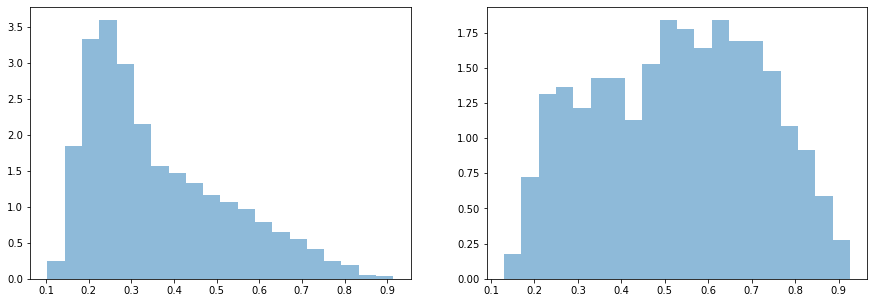

In [473]:
pr_pos = bg[bg['y'] == 1]
pr_neg = bg[bg['y'] == 0]

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist([pr_neg['preds1']], bins=20, alpha=0.5, density=True)

plt.subplot(1,2,2)
plt.hist([pr_pos['preds1']], bins=20, alpha=0.5, density=True)

In [77]:
new_cols

Index(['est_age', 'low_inc', 'ccsp_236_239', 'cms_partd_ra_factor_amt',
       'ccsp_239_ind', 'cms_rx_risk_score_nbr', 'cms_tot_partd_payment_amt',
       'cms_low_income_ind', 'betos_o1a_pmpm_ct', 'cms_disabled_ind', 'bh_tot',
       'cms_risk_adjustment_factor_a_amt', 'cms_risk_adj_payment_rate_b_amt',
       'total_ambulance_visit_ct_pmpm', 'cms_tot_ma_payment_amt',
       'cons_hhcomp_B', 'rx_bh_pmpm_ct', 'cms_ma_risk_score_nbr',
       'rev_cms_er_ind', 'med_plus_total_er_visit', 'mabh_seg_H2',
       'med_ambulance_visit_ct_pmpm', 'cons_online_buyer',
       'cms_dual_eligible_ind', 'cons_n2pmv', 'betos_o1e_pmpm_ct',
       'cons_hhcomp_nan', 'cons_ret_y', 'betos_m1b_pmpm_ct',
       'cmsd2_skn_radiation_ind', 'betos_m5d_pmpm_ct',
       'credit_hh_mtgcredit_new', 'credit_hh_nonmtgcredit_60dpd',
       'ccsp_220_ind', 'submcc_men_alco_pmpm_ct', 'credit_hh_nonagnfirstmtg',
       'cons_hhcomp_A', 'credit_hh_bankcard_severederog', 'rx_gpi2_72_pmpm_ct',
       'bh_aoth_ind', 'rx_gp

In [186]:
newcols

Index(['cms_rx_risk_score_nbr', 'est_age', 'ccsp_239_ind',
       'cms_low_income_ind', 'cms_partd_ra_factor_amt', 'ccsp_236_239',
       'low_inc', 'tot_ambulance_visit_pmpm', 'total_ambulance_visit_ct_pmpm',
       'cms_disabled_ind',
       ...
       'prov_spec_med_supply_ind', 'credit_num_mtg_collections',
       'credit_num_nonmtgcredit_60dpd', 'submcc_gus_kub_pmpm_ct',
       'credit_hh_agencyfirstmtg_new', 'submcc_rsk_obe_pmpm_ct',
       'credit_bal_agency1stmorg_collectio', 'submcc_rsk_smok_pmpm_ct',
       'submcc_cir_hbp_pmpm_ct', 'rx_gpi2_02_pmpm_ct'],
      dtype='object', length=242)